In [1]:
import torch
import numpy as np
import os
from pathlib import Path

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.linalg import sqrtm
from einops import rearrange

from bliss.models.galaxy_net import OneCenteredGalaxyAE
from bliss.models.galaxy_flow import CenteredGalaxyLatentFlow
from bliss.datasets.galsim_galaxies import SDSSGalaxies

In [2]:

os.chdir("../..")

In [3]:
from case_studies.sdss_galaxies.main import get_sdss_data

Global seed set to 0


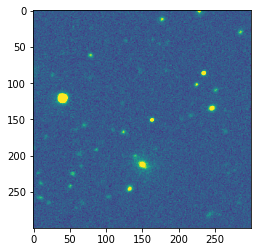

In [4]:
sdss_data = get_sdss_data()
%matplotlib inline
plt.imshow(sdss_data['image'][1150:1450, 1000:1300], vmax=1200)

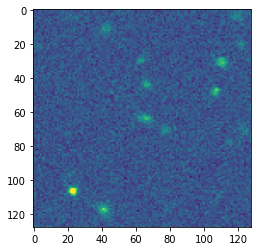

In [5]:
pt = (1408, 1008)
slen = 40
bp = 24
tot = slen + bp

img_of_interest = sdss_data['image'][(pt[0]-tot):(pt[0]+tot), (pt[1]-tot):(pt[1]+tot)]
plt.imshow(img_of_interest, vmax=1200)


In [6]:
from importlib import reload
import bliss.encoder
reload(bliss.encoder)
#from bliss.encoder import Encoder

<module 'bliss.encoder' from '/home/dereklh/projects/bliss2/bliss/encoder.py'>

In [7]:
from bliss.encoder import Encoder
from bliss.models.location_encoder import LocationEncoder, get_params_in_batches
from bliss.models.binary import BinaryEncoder
from bliss.models.galaxy_encoder import GalaxyEncoder
from bliss.sleep import SleepPhase

In [8]:
sleep = SleepPhase.load_from_checkpoint("models/sdss_sleep.ckpt")
binary = BinaryEncoder.load_from_checkpoint("models/sdss_binary.ckpt")
galaxy = GalaxyEncoder.load_from_checkpoint("models/sdss_galaxy_encoder.ckpt")
location = sleep.image_encoder
dec = sleep.image_decoder

INFO: Loading trained normalizing flow for galaxy latents
INFO: Loading trained normalizing flow for galaxy latents


In [9]:
#bliss_encoder = Encoder()
encoder = bliss.encoder.Encoder(location.eval(), binary.eval(), galaxy.eval())

In [10]:
img_tensor = torch.from_numpy(img_of_interest).unsqueeze(0).unsqueeze(0)
img_ptiles = encoder.get_images_in_ptiles(img_tensor)


with torch.no_grad():
    tile_map = encoder.max_a_post(img_ptiles)
    tile_map = get_params_in_batches(tile_map, 1)
    recon_image, _ = dec.render_images(
                    tile_map["n_sources"],
                    tile_map["locs"],
                    tile_map["galaxy_bool"],
                    tile_map["galaxy_param"],
                    tile_map["fluxes"],
                    add_noise=False,
                )

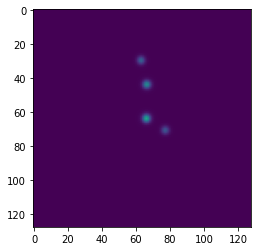

In [11]:
%matplotlib inline

plt.imshow(recon_image[0,0], vmax=1200)

In [12]:
tile_map["galaxy_bool"].sum()

tensor(0.)

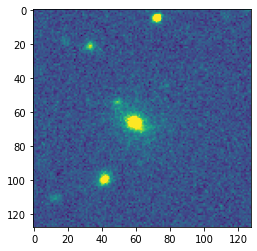

In [13]:
pt = (1360, 1155)
slen = 40
bp = 24
tot = slen + bp

img_of_interest = sdss_data['image'][(pt[0]-tot):(pt[0]+tot), (pt[1]-tot):(pt[1]+tot)]
plt.imshow(img_of_interest, vmax=1200)

In [14]:
def reconstruct_img(img_of_interest):
    img_tensor = torch.from_numpy(img_of_interest).unsqueeze(0).unsqueeze(0)
    img_ptiles = encoder.get_images_in_ptiles(img_tensor)

    with torch.no_grad():
        tile_map = encoder.max_a_post(img_ptiles)
        tile_map = get_params_in_batches(tile_map, 1)
        recon_image, _ = dec.render_images(
                        tile_map["n_sources"],
                        tile_map["locs"],
                        tile_map["galaxy_bool"],
                        tile_map["galaxy_param"],
                        tile_map["fluxes"],
                        add_noise=False,
                    )
    return recon_image

In [15]:
recon_image = reconstruct_img(img_of_interest)

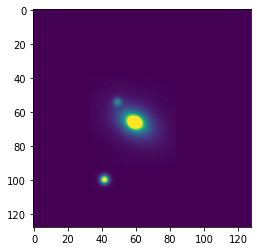

In [16]:
%matplotlib inline

plt.imshow(recon_image[0,0], vmax=1200)

In [17]:
recon_image.shape

torch.Size([1, 1, 128, 128])

In [18]:
img_of_interest.shape

(128, 128)

In [20]:
sleep = SleepPhase.load_from_checkpoint("models/sdss_sleep.ckpt").to("cuda").eval()
binary = BinaryEncoder.load_from_checkpoint("models/sdss_binary.ckpt").to("cuda").eval()
galaxy = GalaxyEncoder.load_from_checkpoint("models/sdss_galaxy_encoder.ckpt").to("cuda").eval()
location = sleep.image_encoder.to("cuda").eval()
dec = sleep.image_decoder.to("cuda").eval()

INFO: Loading trained normalizing flow for galaxy latents
INFO: Loading trained normalizing flow for galaxy latents


In [21]:
#bliss_encoder = Encoder()
encoder = bliss.encoder.Encoder(location.eval(), binary.eval(), galaxy).to("cuda")

In [22]:
from torch.nn import functional as F
from tqdm import tqdm
def reconstruct_scene(img_of_interest, slen=80, bp=24):
    kernel_size = (slen+bp*2)
    chunks = F.unfold(img_of_interest, kernel_size=kernel_size, stride=slen)
    chunks = rearrange(
            chunks,
            "b (c h w) n -> (b n) c h w",
            c=img_of_interest.shape[1],
            h=kernel_size,
            w=kernel_size,
        )
    reconstructions = []
    for chunk in tqdm(chunks):
        recon = reconstruct_img(chunk.unsqueeze(0).cuda()).cpu()
        reconstructions.append(recon)
    reconstructions = torch.cat(reconstructions, dim=0)
    return reconstructions
    reconstructions = rearrange(
        reconstructions, 
        "(b n) c h w -> b (c h w) n", 
        b=img_of_interest.shape[0],
        c=img_of_interest.shape[1],
        h=kernel_size,
        w=kernel_size,
    )

    folded_image = F.fold(reconstructions, img_of_interest.shape[-2:], kernel_size, stride=slen)
    return folded_image

def reconstruct_img(img_of_interest):
    img_ptiles = encoder.get_images_in_ptiles(img_of_interest)

    with torch.no_grad():
        tile_map = encoder.max_a_post(img_ptiles)
        tile_map = get_params_in_batches(tile_map, 1)
        recon_image, _ = dec.render_images(
                        tile_map["n_sources"],
                        tile_map["locs"],
                        tile_map["galaxy_bool"],
                        tile_map["galaxy_param"],
                        tile_map["fluxes"],
                        add_noise=False,
                    )
    return recon_image

In [40]:
import bliss.reconstruct as reconstruct
reload(reconstruct)

<module 'bliss.reconstruct' from '/home/dereklh/projects/bliss2/bliss/reconstruct.py'>

In [23]:
dec = dec.eval()
from bliss.predict import predict_on_image
def reconstruct_img2(img_of_interest):
    with torch.no_grad():
        tile_map,_,_ = predict_on_image(img_of_interest, location, binary, galaxy.eval())
        recon_image, _ = dec.render_images(
                        tile_map["n_sources"],
                        tile_map["locs"],
                        tile_map["galaxy_bool"],
                        tile_map["galaxy_params"],
                        tile_map["fluxes"],
                        add_noise=False,
                    )
    return recon_image

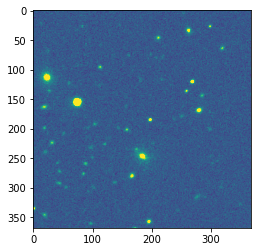

In [24]:
sdss1_with_bp = sdss_data['image'][(1150-bp-10):(1450+bp+10), (1000-bp-10):(1300+bp+10)]
%matplotlib inline
plt.imshow(sdss1_with_bp, vmax=1200)

In [25]:
sdss1_with_bp_torch = torch.from_numpy(sdss1_with_bp).unsqueeze(0).unsqueeze(0)
recon1 = reconstruct_scene(sdss1_with_bp_torch)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36it/s]


In [26]:
rr = rearrange(recon1 - 865, "(b n) c h w -> b (c h w) n", b=1, c=1)
output_size = 3 * 80 + 128
output_size = sdss1_with_bp_torch.shape[-1]
rr.shape
rrr= F.fold(rr, output_size = output_size, kernel_size=(128, 128), stride=(80, 80))
#rfinal = F.pad(rrr, (0, sdss1_with_bp_torch.shape[2] - output_size, 0, sdss1_with_bp_torch.shape[3] - output_size)) + 865
rfinal = rrr + 865

In [31]:
3:8

SyntaxError: illegal target for annotation (268700432.py, line 1)

In [27]:
sdss1_with_bp_torch.shape[-2], sdss1_with_bp_torch.shape[-1]

(368, 368)

In [101]:
3 * 80 + 128

368

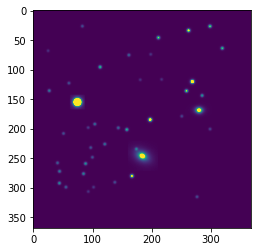

In [102]:
%matplotlib inline
plt.imshow(rfinal[0,0], vmax=1200)

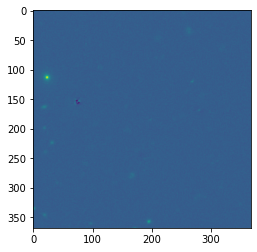

In [103]:
%matplotlib inline
residd=(sdss1_with_bp_torch-rfinal)/rfinal.sqrt()
plt.imshow(residd[0,0])

In [152]:
reload(reconstruct)
sdss1_with_bp_torch = torch.from_numpy(sdss1_with_bp).unsqueeze(0).unsqueeze(0)
recon1 = reconstruct.reconstruct_scene(encoder, dec, sdss1_with_bp_torch)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.98it/s]

torch.Size([1, 16384, 16])
torch.Size([1, 16384, 16])


In [138]:
recon1.shape

torch.Size([1, 1, 368, 368])

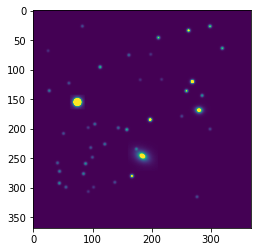

In [144]:
%matplotlib inline
plt.imshow(recon1[0,0], vmax=1200)

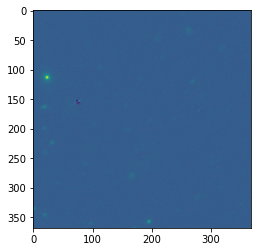

In [151]:
%matplotlib inline
residd=(sdss1_with_bp_torch-recon1)/rfinal.sqrt()
plt.imshow(residd[0,0])

IndexError: index 1 is out of bounds for dimension 0 with size 1

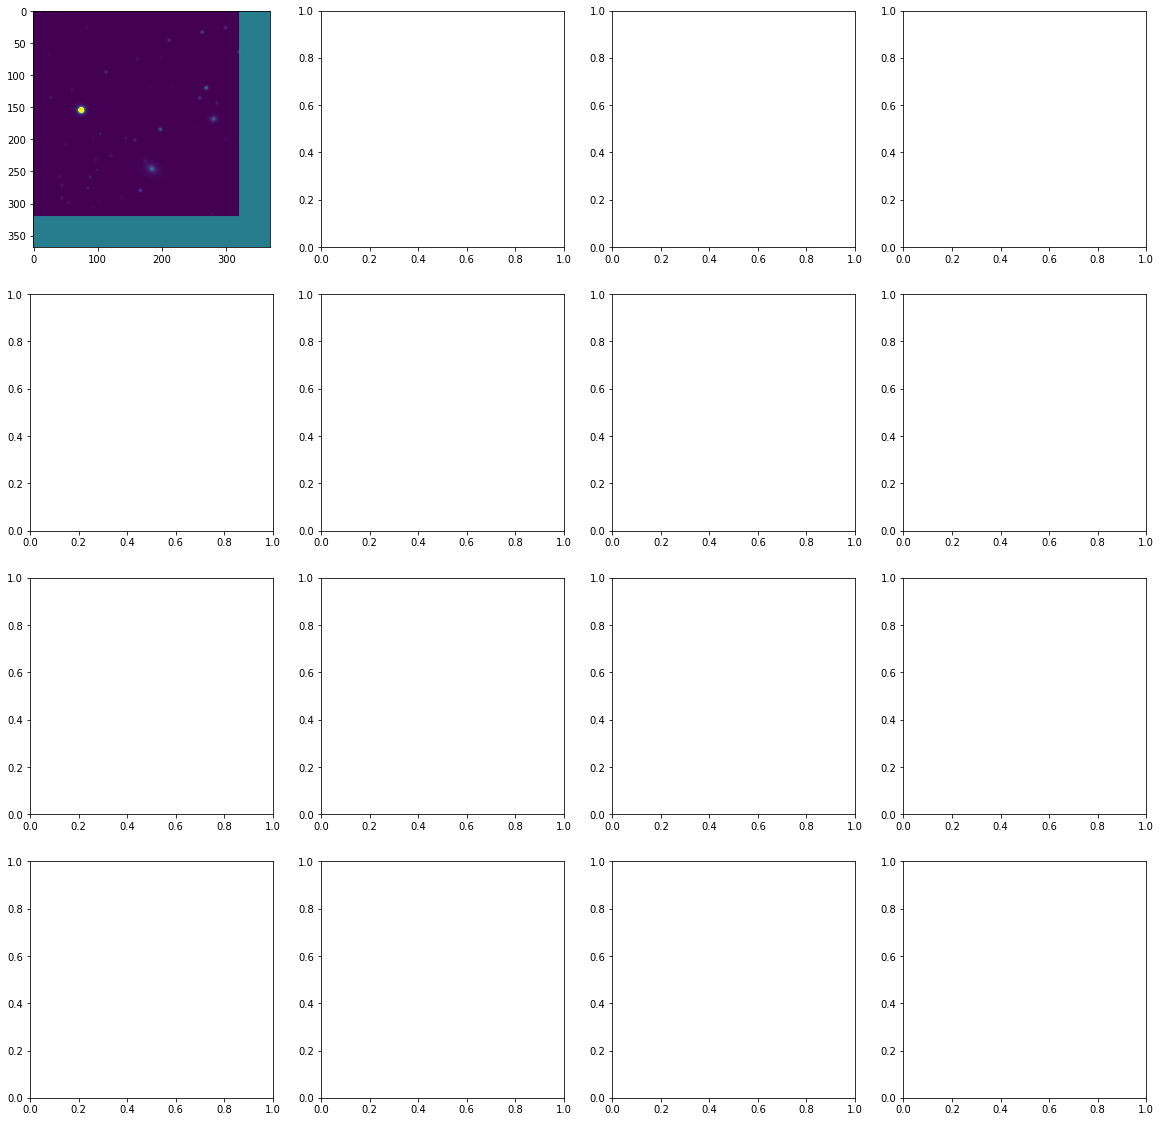

In [131]:
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for (i, ax) in enumerate(axes.flatten()):
    ax.imshow(recon1[i,0,:,:], vmax=1200)

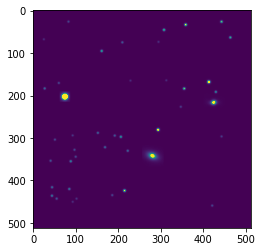

In [118]:
%matplotlib inline
r = rearrange(recon1, "(nh nw) 1 h w -> 1 1 (nh h) (nw w)", nh=4)
plt.imshow(r[0,0], vmax=1200)

In [119]:
r.shape

torch.Size([1, 1, 512, 512])

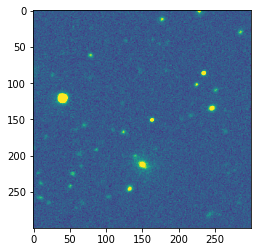

In [154]:
sdss_data = get_sdss_data()
my_image = torch.from_numpy(sdss_data['image']).unsqueeze(0).unsqueeze(0)
%matplotlib inline
plt.imshow(my_image[0,0,1150:1450, 1000:1300], vmax=1200)

In [167]:
reload(reconstruct)
recon_at_cood1 = reconstruct.reconstruct_scene_at_coordinates(encoder, dec, my_image, 1150, 1000, 300)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.81it/s]

torch.Size([1, 16384, 16])
torch.Size([1, 16384, 16])


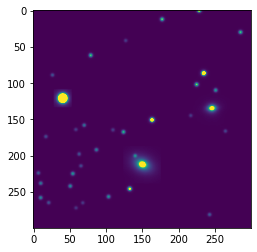

In [168]:
%matplotlib inline
plt.imshow(recon_at_cood1[0,0], vmax=1200)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.03it/s]

torch.Size([1, 16384, 16])
torch.Size([1, 16384, 16])


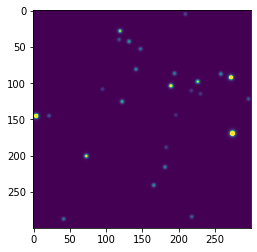

In [170]:
recon_at_cood0 = reconstruct.reconstruct_scene_at_coordinates(
    encoder, dec, my_image, 200, 1700, 300
)
%matplotlib inline
plt.imshow(recon_at_cood0[0,0], vmax=1200)

In [166]:
recon_at_cood0

tensor([], size=(1, 1, 0, 300))